# SETTING UP THE ENV

Lets impot Libraries

In [1]:
#download necessary libraries

!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.9 MB/s eta 0:00:00


In [2]:
import sys
sys.path.append('/kaggle/working')
# !ls /kaggle/working
import torch
print(torch.__version__)
print(torch.version.cuda)

2.1.2
12.1


In [3]:
from typing import Union, Tuple
from torch_geometric.typing import OptPairTensor, Adj, Size # Optional[Tensor], Union[Tensor, SparseTensor], Optional[Tuple[int, int]], all about data type

from torch import Tensor
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn.conv import MessagePassing

In [4]:
import warnings
warnings.filterwarnings("ignore")
import os
import time
import random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
import torch_geometric.nn as gnn
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Dataset, Data, DataLoader
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.utils import softmax
from sklearn.metrics import r2_score

# Pre Processing

In [5]:
df = pd.read_csv('/kaggle/input/cms-dataset/CMS_trigger.csv')
print(df.columns)

Index(['Unnamed: 0', 'Phi_0', 'Phi_2', 'Phi_3', 'Phi_4', 'Theta_0', 'Theta_2',
       'Theta_3', 'Theta_4', 'BendingAngle_0', 'BendingAngle_2',
       'BendingAngle_3', 'BendingAngle_4', 'TimeInfo_0', 'TimeInfo_2',
       'TimeInfo_3', 'TimeInfo_4', 'RingNumber_0', 'RingNumber_2',
       'RingNumber_3', 'RingNumber_4', 'Front_0', 'Front_2', 'Front_3',
       'Front_4', 'Mask_0', 'Mask_2', 'Mask_3', 'Mask_4',
       'PatternStraightness', 'Zone', 'MedianTheta', 'q/pt', 'PhiAngle',
       'EtaAngle'],
      dtype='object')


In [6]:
df.head()

,Unnamed: 0,Phi_0,Phi_2,Phi_3,Phi_4,Theta_0,Theta_2,Theta_3,Theta_4,BendingAngle_0,...,Mask_0,Mask_2,Mask_3,Mask_4,PatternStraightness,Zone,MedianTheta,q/pt,PhiAngle,EtaAngle
0,0,58.066666,55.466667,55.466667,56.000000,11.970,11.684999,11.400,11.400,-13.000000,...,0.0,0.0,0.0,0.0,5.0,3.0,105.0,0.181209,-3.075936,1.722345
1,1,64.583336,66.800000,67.066666,67.200000,6.555,6.840000,6.555,6.840,7.000000,...,0.0,0.0,0.0,0.0,3.0,1.0,124.0,-0.146131,-0.167139,2.012122
2,2,71.150000,67.033330,66.266670,65.466670,2.850,2.565000,2.280,2.280,-16.613783,...,0.0,0.0,0.0,0.0,7.0,0.0,127.0,0.367024,2.431823,2.321646
3,3,34.933334,31.200000,31.200000,31.833334,9.690,8.835000,8.835,9.120,-13.000000,...,0.0,0.0,0.0,0.0,6.0,2.0,60.0,0.267774,-1.343305,1.854506
4,4,68.150000,68.266670,68.300000,68.400000,2.565,2.565000,2.565,2.565,0.000000,...,0.0,0.0,0.0,0.0,4.0,0.0,128.0,-0.019179,-3.134433,2.333772


In [7]:
df.describe()

,Unnamed: 0,Phi_0,Phi_2,Phi_3,Phi_4,Theta_0,Theta_2,Theta_3,Theta_4,BendingAngle_0,...,Mask_0,Mask_2,Mask_3,Mask_4,PatternStraightness,Zone,MedianTheta,q/pt,PhiAngle,EtaAngle
count,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,...,1179356.0,1179356.0,1179356.0,1179356.0,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06
mean,5.896775e+05,4.851559e+01,4.851127e+01,4.851076e+01,4.851331e+01,6.195453e+00,5.918753e+00,5.848332e+00,5.881490e+00,5.603115e-02,...,0.0,0.0,0.0,0.0,3.976490e+00,1.080514e+00,9.115961e+01,5.540485e-04,8.881380e-04,8.762006e-04
std,3.404509e+05,1.774647e+01,1.779697e+01,1.781670e+01,1.779750e+01,3.011983e+00,2.921076e+00,2.911875e+00,2.906416e+00,1.493805e+01,...,0.0,0.0,0.0,0.0,1.871622e+00,1.089190e+00,3.328909e+01,2.524173e-01,1.820920e+00,2.075298e+00
min,0.000000e+00,1.103333e+01,2.400000e+00,2.666667e+00,2.666667e+00,1.425000e+00,1.425000e+00,1.425000e+00,1.710000e+00,-1.329103e+02,...,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,8.000000e+00,-4.999928e-01,-3.141584e+00,-2.499009e+00
25%,2.948388e+05,3.371667e+01,3.360000e+01,3.360000e+01,3.360000e+01,3.705000e+00,3.420000e+00,3.420000e+00,3.420000e+00,-1.100000e+01,...,0.0,0.0,0.0,0.0,3.000000e+00,0.000000e+00,6.300000e+01,-2.055347e-01,-1.584667e+00,-2.074832e+00
50%,5.896775e+05,4.830000e+01,4.826667e+01,4.826667e+01,4.826667e+01,5.700000e+00,5.415000e+00,5.415000e+00,5.415000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,4.000000e+00,1.000000e+00,9.100000e+01,2.155910e-04,8.142424e-03,1.523139e+00
75%,8.845162e+05,6.326667e+01,6.303333e+01,6.293333e+01,6.296667e+01,8.265000e+00,7.980000e+00,7.695000e+00,7.980000e+00,1.100000e+01,...,0.0,0.0,0.0,0.0,5.000000e+00,2.000000e+00,1.180000e+02,2.069167e-01,1.581958e+00,2.074729e+00
max,1.179355e+06,8.311667e+01,8.256667e+01,8.253333e+01,8.253333e+01,1.510500e+01,1.396500e+01,1.539000e+01,1.510500e+01,1.421401e+02,...,0.0,0.0,0.0,0.0,8.000000e+00,4.000000e+00,1.540000e+02,4.999991e-01,3.141592e+00,2.493834e+00


In [8]:
#HOW MOMENTUM NEGATIVE??

**The data is not scaled, so we would have to scale the data first before we proceed to train a model on the data**

**To begin with lets  scale the data by using Standard Scalar**

In [9]:
scaler = StandardScaler()

In [10]:
df.loc[:,"Phi_0":"MedianTheta"] = scaler.fit_transform(df.loc[:,"Phi_0":"MedianTheta"])

In [11]:
df.describe()

,Unnamed: 0,Phi_0,Phi_2,Phi_3,Phi_4,Theta_0,Theta_2,Theta_3,Theta_4,BendingAngle_0,...,Mask_0,Mask_2,Mask_3,Mask_4,PatternStraightness,Zone,MedianTheta,q/pt,PhiAngle,EtaAngle
count,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,...,1179356.0,1179356.0,1179356.0,1179356.0,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06
mean,5.896775e+05,7.146661e-17,-2.706296e-16,-7.705465e-16,-3.355171e-16,-2.781065e-16,8.641905e-16,6.533453e-16,3.205695e-16,2.842518e-17,...,0.0,0.0,0.0,0.0,-4.221603e-17,-8.916758e-18,1.504040e-16,5.540485e-04,8.881380e-04,8.762006e-04
std,3.404509e+05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.0,0.0,0.0,0.0,1.000000e+00,1.000000e+00,1.000000e+00,2.524173e-01,1.820920e+00,2.075298e+00
min,0.000000e+00,-2.112098e+00,-2.590963e+00,-2.573098e+00,-2.576017e+00,-1.583825e+00,-1.538390e+00,-1.519067e+00,-1.435270e+00,-8.901182e+00,...,0.0,0.0,0.0,0.0,-2.124623e+00,-9.920352e-01,-2.498105e+00,-4.999928e-01,-3.141584e+00,-2.499009e+00
25%,2.948388e+05,-8.339083e-01,-8.378547e-01,-8.368982e-01,-8.379445e-01,-8.268486e-01,-8.554224e-01,-8.339413e-01,-8.469162e-01,-7.401255e-01,...,0.0,0.0,0.0,0.0,-5.217347e-01,-9.920352e-01,-8.459116e-01,-2.055347e-01,-1.584667e+00,-2.074832e+00
50%,5.896775e+05,-1.214813e-02,-1.374387e-02,-1.370004e-02,-1.385850e-02,-1.644940e-01,-1.724547e-01,-1.488154e-01,-1.605036e-01,-3.750902e-03,...,0.0,0.0,0.0,0.0,1.256146e-02,-7.392128e-02,-4.794768e-03,2.155910e-04,8.142424e-03,1.523139e+00
75%,8.845162e+05,8.312126e-01,8.159859e-01,8.094982e-01,8.121005e-01,6.871047e-01,7.056466e-01,6.341855e-01,7.220270e-01,7.326237e-01,...,0.0,0.0,0.0,0.0,5.468577e-01,8.441926e-01,8.062822e-01,2.069167e-01,1.581958e+00,2.074729e+00
max,1.179355e+06,1.949746e+00,1.913552e+00,1.909590e+00,1.911506e+00,2.958035e+00,2.754550e+00,3.276814e+00,3.173501e+00,9.511558e+00,...,0.0,0.0,0.0,0.0,2.149746e+00,2.680420e+00,1.887718e+00,4.999991e-01,3.141592e+00,2.493834e+00


**We can see that the std dev and the mean has been transformed to 1 and 0 respectively**

In [12]:
features = list(df.columns)[1:29]
features

['Phi_0',
 'Phi_2',
 'Phi_3',
 'Phi_4',
 'Theta_0',
 'Theta_2',
 'Theta_3',
 'Theta_4',
 'BendingAngle_0',
 'BendingAngle_2',
 'BendingAngle_3',
 'BendingAngle_4',
 'TimeInfo_0',
 'TimeInfo_2',
 'TimeInfo_3',
 'TimeInfo_4',
 'RingNumber_0',
 'RingNumber_2',
 'RingNumber_3',
 'RingNumber_4',
 'Front_0',
 'Front_2',
 'Front_3',
 'Front_4',
 'Mask_0',
 'Mask_2',
 'Mask_3',
 'Mask_4']

In [13]:
# Lets split the data into train and the test splits

In [14]:
train_idx, test_idx = train_test_split(df['Unnamed: 0'].to_numpy(), test_size = 0.2, random_state = 1)
x_data = df[features].to_numpy()
pT = abs(1/df.loc[:,'q/pt']).to_numpy()
label = pT
num_features = x_data.shape[-1]
print('Data shape: ' + str(x_data.shape))
print(pT.shape)
print('Len train: '+str(len(train_idx))+', Len test: '+str(len(test_idx)))
print('Num. features: '+str(num_features))

Data shape: (1179356, 28)
(1179356,)
Len train: 943484, Len test: 235872
Num. features: 28


In [15]:
label.min(), label.max()

(2.00000380000722, 6955.5709428241635)

# Dataset Class and Data Loaders

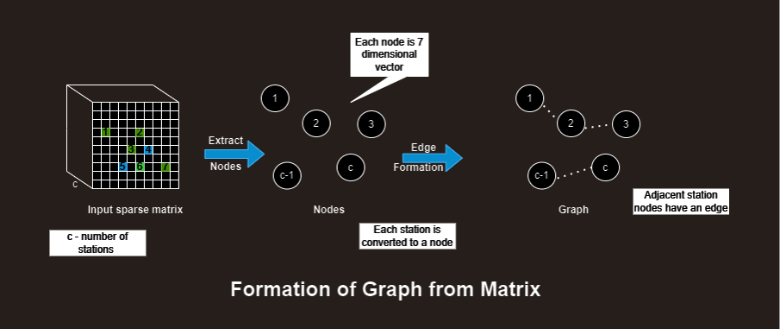

**The dataset is having 28 features extracted from 4 triggers ie 7 features per trigger**

**Total approached to try**

---------------------------------------------------------------------------------------------------------------------------
**(THIS NOTEBOOK)**

- [x] **Each station as a node : 
    Here basically each station(4),is made a node of the graph and the node feature is the features recieved at the respective station(7)**
    
    Here,
         Total nodes = 4
         node feature length = 7
         edges should be between these 4 nodes (Yet to find out the best way to decide across which two nodes there should be and edge)
    
    
---------------------------------------------------------------------------------------------------------------------------
- [ ] **Each feature as a node :
    Here basically each feature obtianed from different stations, here 4 stations are made a node of the graph and 
    the node feature is the values of this feature across the 4 different stations**
    
    Here,
         Total nodes = 7
         node feature length = 4
         edges should be between these 7 nodes (Yet to find out the best way to decide across which two nodes there should be and edge)
         
---------------------------------------------------------------------------------------------------------------------------

- [ ]  **Each patch as a node :
    Here basically the data is converted into 7*4 matrix and then would have to split this into patches and then the features of the noden would be the flattened pixel values in each patch**
    
    Here,
         Total nodes = total_patches 
         node feature length = pixels in each path
         edges should be between these patch nodes (Yet to find out the best way to decide across which two nodes there should be and edge
         
---------------------------------------------------------------------------------------------------------------------------

In [16]:
# x_data.shape

In [17]:
class Graph_dataset(Dataset):
    def __init__(self, dataset , label,  edge_index, indices, transform=None):
        self.transform = transform
        self.data = dataset
        self.edge_index = edge_index
        self.indices = indices
        self.label = label
    
    def __getitem__(self, idx):
        return self.convert_to_graph(self.indices[idx])
    
    def __len__(self):
        return len(self.indices)
    
    def convert_to_graph(self, i):
    
        data = Data(x=torch.tensor(self.data[i].reshape(-1,4).T, dtype=torch.float), y=torch.tensor(self.label[i], dtype=torch.float),
                    edge_index=torch.tensor(self.edge_index, dtype = torch.long).T)
        return data

In [18]:
edge_index = [(0,1),(1,2),(2,3),(3,2),(2,1),(1,0)]

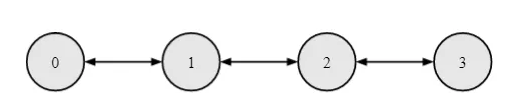

In [19]:
train_dataset = Graph_dataset(x_data, label, edge_index , train_idx)
next(iter(train_dataset))

Data(x=[4, 7], edge_index=[2, 6], y=9.726032257080078)

In [20]:
train_loader = DataLoader(Graph_dataset(x_data, label, edge_index , train_idx), batch_size=512)
test_loader = DataLoader(Graph_dataset(x_data, label, edge_index , test_idx), batch_size=256)

In [21]:
next(iter(train_loader))

DataBatch(x=[2048, 7], edge_index=[2, 3072], y=[512], batch=[2048], ptr=[513])

**We are all set with the dataset and the dataloader**

# Lets set the Model

In [22]:
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.utils import to_dense_batch
import torch
import torch.nn as nn
import torch.nn.functional as F

In [23]:
class MODEL_GNN(torch.nn.Module):
    def __init__(self):
        super(MODEL_GNN, self).__init__()
        self.conv1 = GCNConv(int(len(features)/4),128 )
        self.conv2 = GATConv(128,64)
        self.conv3 = GATConv(64,64 )
        self.conv4 = SAGEConv(64,64 )
        self.lin1 = torch.nn.Linear(128, 128)
        self.lin2 = torch.nn.Linear(128, 16)
        self.lin3 = torch.nn.Linear(16, 16)
        self.lin4 = torch.nn.Linear(16, 1)
        self.lin5 = torch.nn.Linear(128, 128)
        self.lin6 = torch.nn.Linear(128, 16)
        self.lin7 = torch.nn.Linear(16, 16)
        self.lin8 = torch.nn.Linear(16, 1)
        self.global_att_pool1 = gnn.GlobalAttention(torch.nn.Sequential(torch.nn.Linear(64, 1)))
        self.global_att_pool2 = gnn.GlobalAttention(torch.nn.Sequential(torch.nn.Linear(64, 1)))
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x1 = self.global_att_pool1(x, batch)
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x2 = self.global_att_pool2(x, batch)
        x_out = torch.cat([x1, x2], dim=1)
        x = F.relu(self.lin1(x_out))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        x = self.lin4(x).squeeze(1)

        return x

In [24]:
# Example usage:
# Initialize your model
model = MODEL_GNN()

In [25]:
model

MODEL_GNN(
  (conv1): GCNConv(7, 128)
  (conv2): GATConv(128, 64, heads=1)
  (conv3): GATConv(64, 64, heads=1)
  (conv4): SAGEConv(64, 64, aggr=mean)
  (lin1): Linear(in_features=128, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=16, bias=True)
  (lin3): Linear(in_features=16, out_features=16, bias=True)
  (lin4): Linear(in_features=16, out_features=1, bias=True)
  (lin5): Linear(in_features=128, out_features=128, bias=True)
  (lin6): Linear(in_features=128, out_features=16, bias=True)
  (lin7): Linear(in_features=16, out_features=16, bias=True)
  (lin8): Linear(in_features=16, out_features=1, bias=True)
  (global_att_pool1): GlobalAttention(gate_nn=Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  ), nn=None)
  (global_att_pool2): GlobalAttention(gate_nn=Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  ), nn=None)
)

In [26]:
# Forward pass with input data x and edge_index

In [27]:
def train(train_loader, test_loader, prog_bar = True):
    
    train_losses, test_losses = list(), list()
    min_test_loss = float('inf')
#     criterion = nn.MSELoss()
    for epoch in range(epochs):
        train_loss = 0
        test_loss = 0
        if prog_bar:
            pbar = tqdm(train_loader,position=0)
        else:
            pbar = train_loader
            
        # train
        for data in pbar:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            labels = data.y
            loss = pTLossTorch(out, data.y)
            loss.backward()
            optimizer.step()
            if prog_bar:
                pbar.set_description('MSEError: '+str(loss.cpu().detach().numpy()))
                train_loss += loss.cpu().detach().numpy()/len(train_loader)
                
        # test
        for data in test_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            labels = data.y
            loss = pTLossTorch(out, data.y)
            test_loss += loss.cpu().detach().numpy()/len(test_loader)
        if test_loss<min_test_loss:
            print('Min loss changed from '+str(min_test_loss)+' to '+str(test_loss))
            min_test_loss = test_loss
            torch.save(model.state_dict(), model_name)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        if epoch > 10 and min(test_losses[-7:])>min_test_loss+1e-9:
            break
        lr_scheduler.step(test_loss)
        print('Epoch: ', str(epoch+1)+'/'+str(epochs),'| Training pTLoss: ', train_loss, '| Testing pTLoss: ', test_loss)
        
        if prog_bar:
            plt.plot(train_losses, label="Train Loss")
            plt.plot(test_losses, label="Validation Loss")
            plt.xlabel("# Epoch")
            plt.ylabel("Loss")
            plt.legend(loc='upper right')
            plt.show()
    return train_losses, test_losses

In [28]:
def pTLossTorch(y_pred,y_true):
#     if not inv:
#         y_pred = torch.pow(y_pred,-1)
#         y_true = torch.pow(y_true,-1)
    y_t = (y_true<80).type(torch.FloatTensor)*y_true.type(torch.FloatTensor) + (y_true>=80).type(torch.FloatTensor)*(y_true<250).type(torch.FloatTensor)*y_true.type(torch.FloatTensor)**2.4 + (y_true>=160).type(torch.FloatTensor)*10 
    return torch.mean(y_t.type(torch.FloatTensor)*torch.pow((y_pred-y_true)/y_true,2).type(torch.FloatTensor))/250

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from inf to 4.467447781058558
Epoch:  1/50 | Training pTLoss:  5.465415500035696 | Testing pTLoss:  4.467447781058558


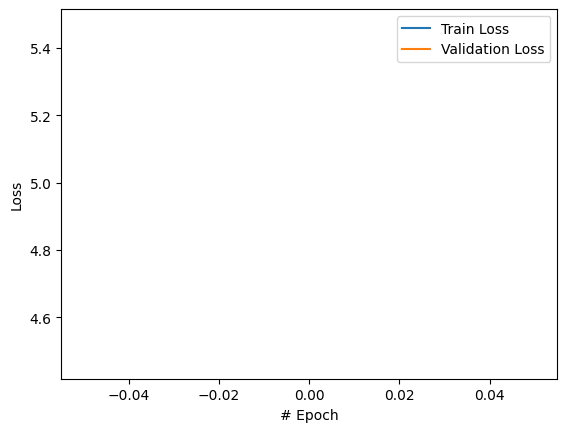

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 4.467447781058558 to 4.311437787241632
Epoch:  2/50 | Training pTLoss:  4.420382712725645 | Testing pTLoss:  4.311437787241632


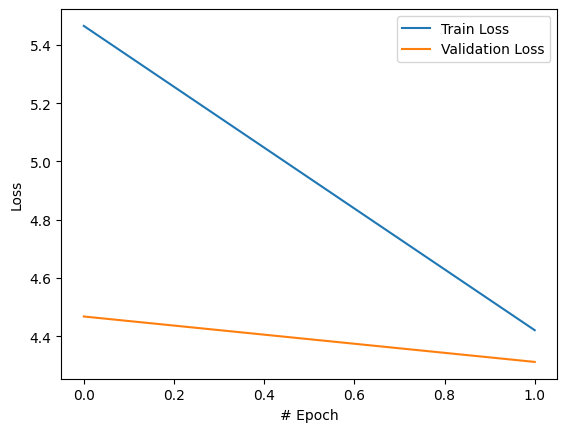

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 4.311437787241632 to 4.2293243872369395
Epoch:  3/50 | Training pTLoss:  4.36628055996178 | Testing pTLoss:  4.2293243872369395


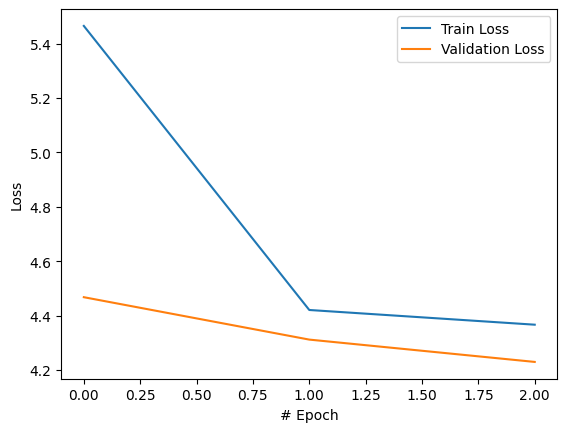

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 4.2293243872369395 to 4.040841549053106
Epoch:  4/50 | Training pTLoss:  4.142687011722375 | Testing pTLoss:  4.040841549053106


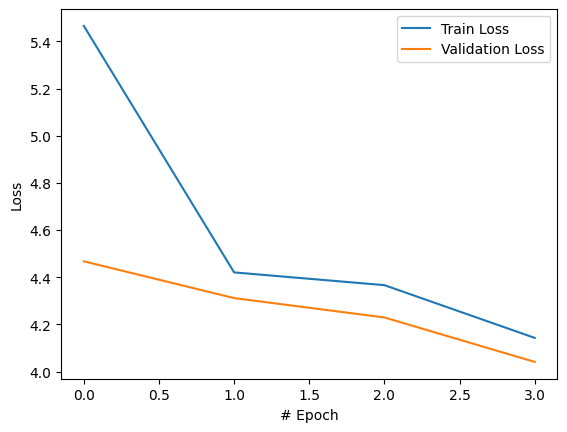

  0%|          | 0/1843 [00:00<?, ?it/s]

Epoch:  5/50 | Training pTLoss:  4.132243774180435 | Testing pTLoss:  4.314338394592229


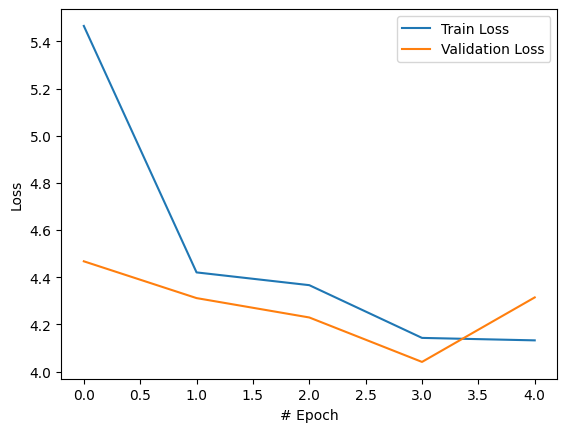

  0%|          | 0/1843 [00:00<?, ?it/s]

Epoch 00006: reducing learning rate of group 0 to 5.0000e-03.
Epoch:  6/50 | Training pTLoss:  4.093313191969374 | Testing pTLoss:  4.1589359551215646


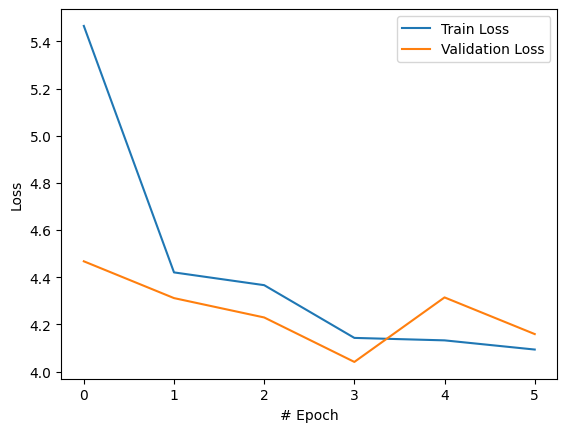

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 4.040841549053106 to 3.8989281847006336
Epoch:  7/50 | Training pTLoss:  4.039757615188762 | Testing pTLoss:  3.8989281847006336


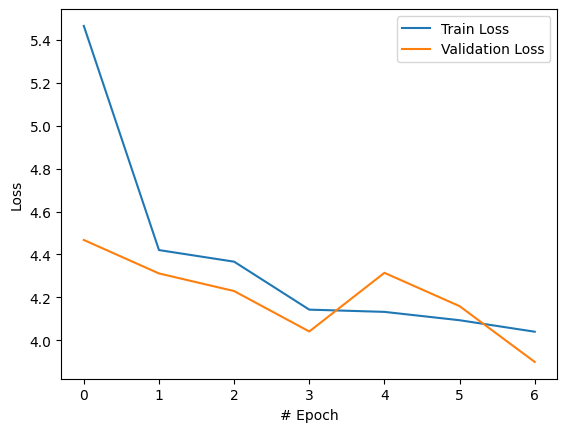

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.8989281847006336 to 3.8787372357933245
Epoch:  8/50 | Training pTLoss:  3.9587549782290896 | Testing pTLoss:  3.8787372357933245


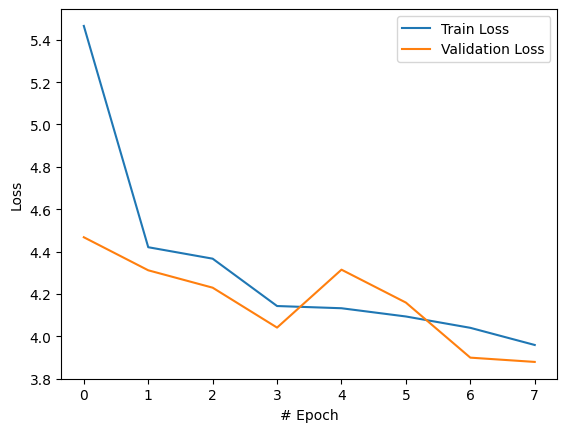

  0%|          | 0/1843 [00:00<?, ?it/s]

Epoch:  9/50 | Training pTLoss:  3.9510954020790465 | Testing pTLoss:  3.928252637450966


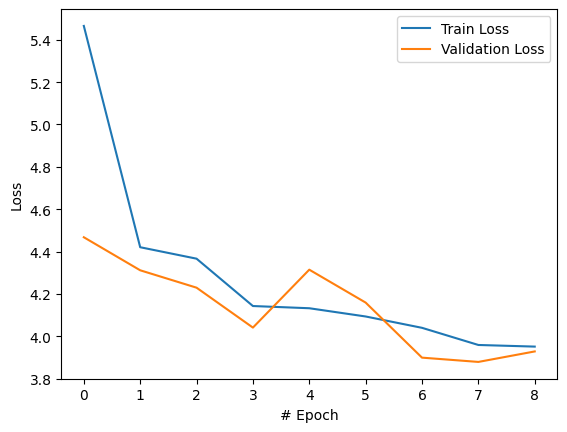

  0%|          | 0/1843 [00:00<?, ?it/s]

Epoch 00010: reducing learning rate of group 0 to 2.5000e-03.
Epoch:  10/50 | Training pTLoss:  3.946812133781305 | Testing pTLoss:  3.904547505614043


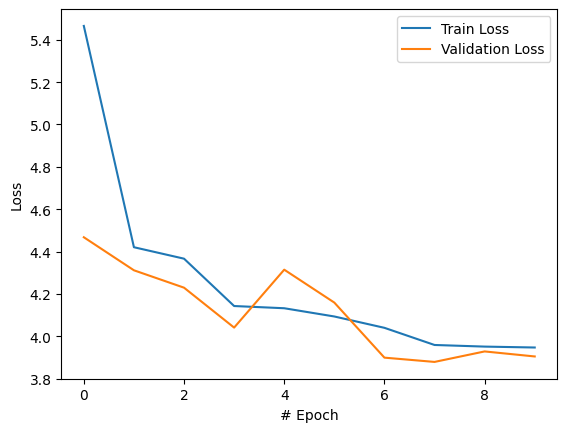

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.8787372357933245 to 3.854201077380565
Epoch:  11/50 | Training pTLoss:  3.901873743346509 | Testing pTLoss:  3.854201077380565


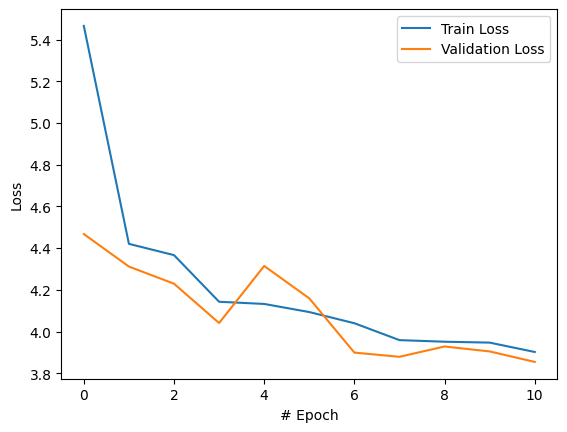

  0%|          | 0/1843 [00:00<?, ?it/s]

Epoch:  12/50 | Training pTLoss:  3.8990362726730052 | Testing pTLoss:  3.858328501857542


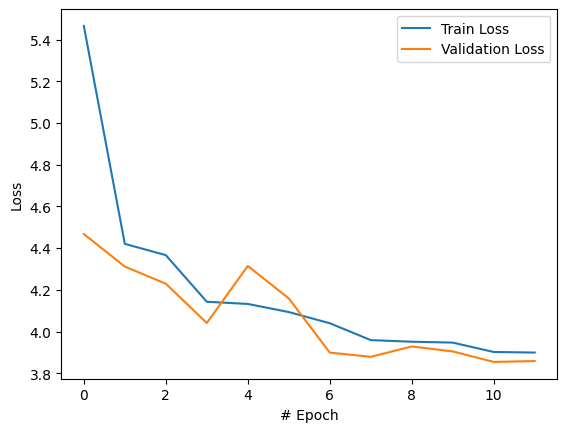

  0%|          | 0/1843 [00:00<?, ?it/s]

Epoch 00013: reducing learning rate of group 0 to 1.2500e-03.
Epoch:  13/50 | Training pTLoss:  3.8964269828744613 | Testing pTLoss:  3.8668010368652297


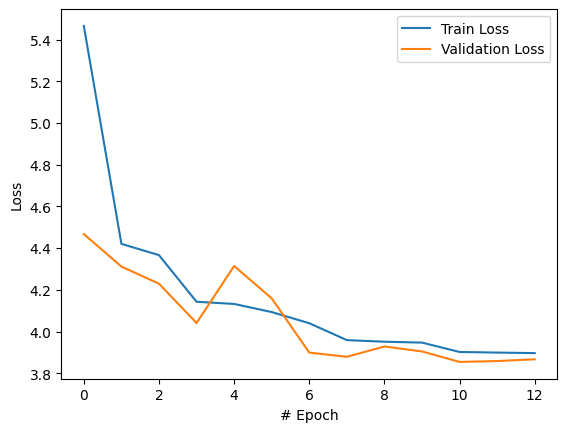

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.854201077380565 to 3.819674925018028
Epoch:  14/50 | Training pTLoss:  3.8680257906554103 | Testing pTLoss:  3.819674925018028


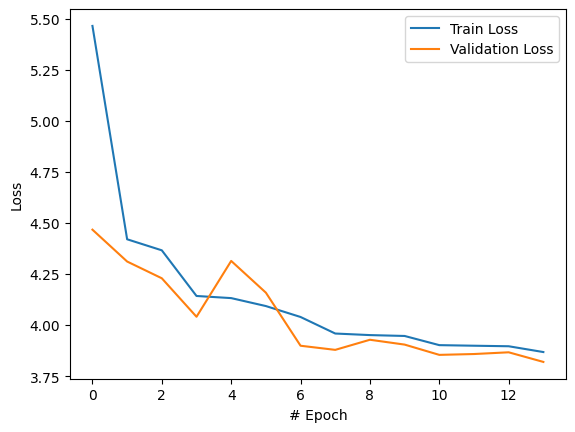

  0%|          | 0/1843 [00:00<?, ?it/s]

Epoch:  15/50 | Training pTLoss:  3.8639159403737358 | Testing pTLoss:  3.8310265184224552


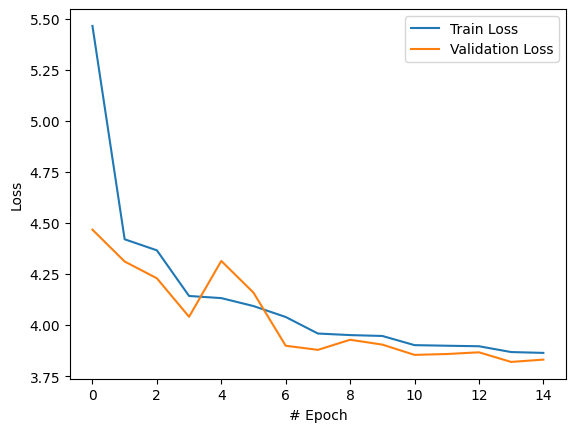

  0%|          | 0/1843 [00:00<?, ?it/s]

Epoch 00016: reducing learning rate of group 0 to 6.2500e-04.
Epoch:  16/50 | Training pTLoss:  3.8645700794552154 | Testing pTLoss:  3.82336603101836


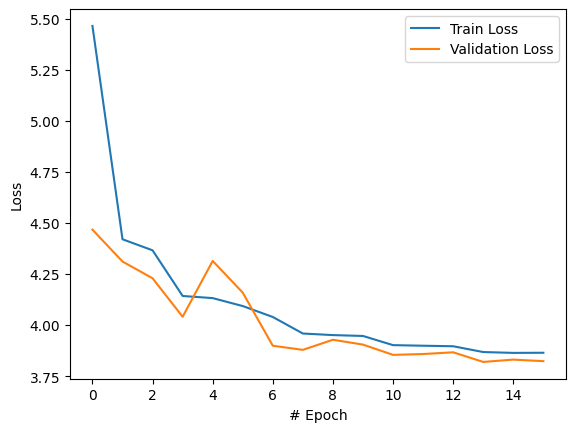

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.819674925018028 to 3.809858903321165
Epoch:  17/50 | Training pTLoss:  3.848005749709699 | Testing pTLoss:  3.809858903321165


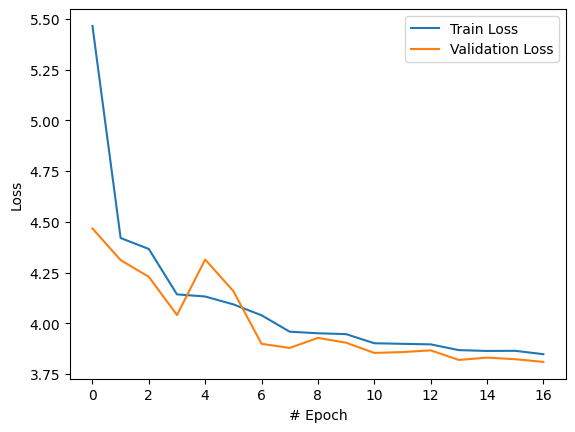

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.809858903321165 to 3.808502100553533
Epoch:  18/50 | Training pTLoss:  3.8459660948066725 | Testing pTLoss:  3.808502100553533


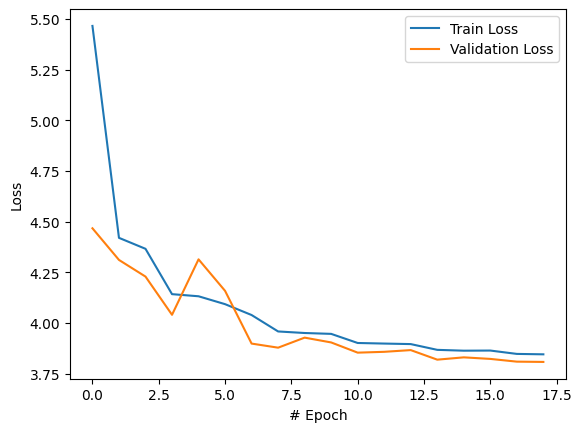

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.808502100553533 to 3.806750884865472
Epoch:  19/50 | Training pTLoss:  3.8443901817629134 | Testing pTLoss:  3.806750884865472


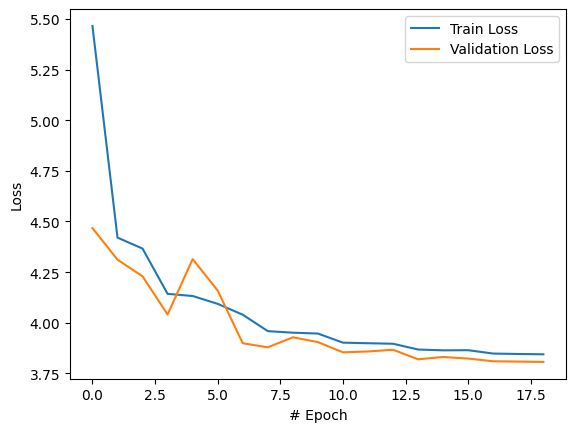

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.806750884865472 to 3.805462111943199
Epoch:  20/50 | Training pTLoss:  3.842592679736286 | Testing pTLoss:  3.805462111943199


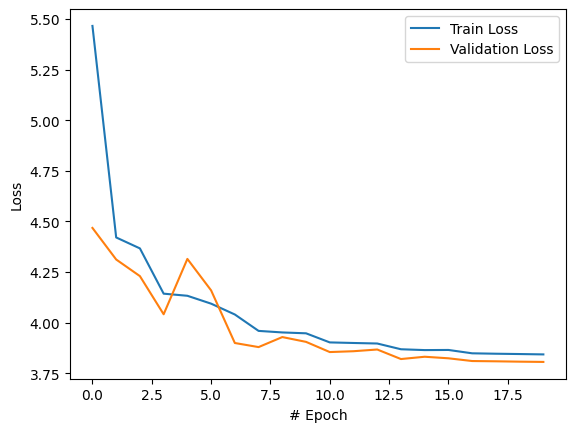

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.805462111943199 to 3.802771921982731
Epoch:  21/50 | Training pTLoss:  3.8411386998140875 | Testing pTLoss:  3.802771921982731


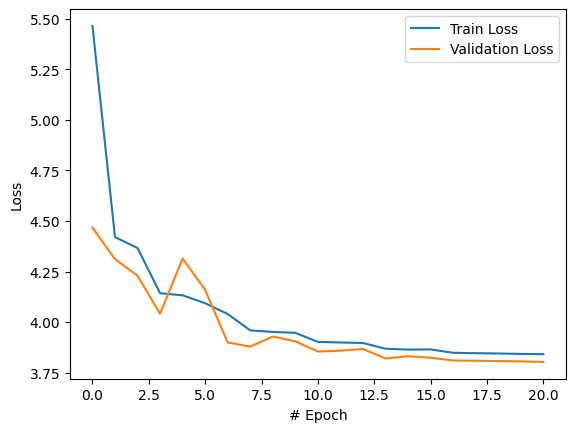

  0%|          | 0/1843 [00:00<?, ?it/s]

Epoch:  22/50 | Training pTLoss:  3.8403449281039506 | Testing pTLoss:  3.8034739211169333


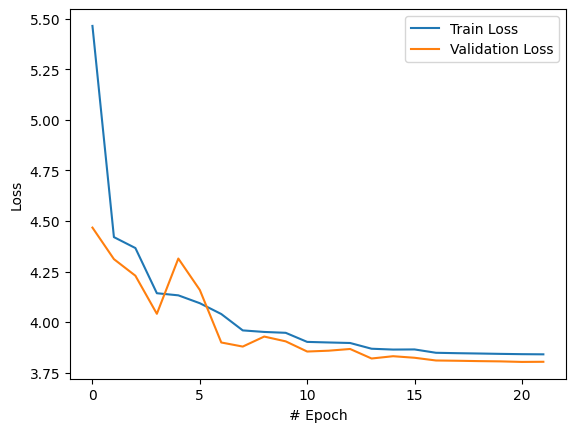

  0%|          | 0/1843 [00:00<?, ?it/s]

Epoch 00023: reducing learning rate of group 0 to 3.1250e-04.
Epoch:  23/50 | Training pTLoss:  3.83894093781791 | Testing pTLoss:  3.8036787827335576


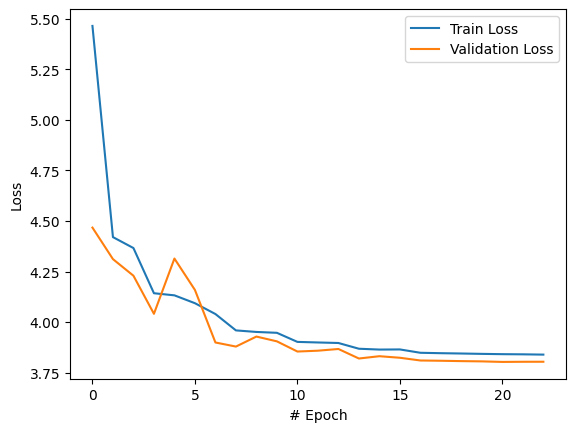

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.802771921982731 to 3.7998728794803323
Epoch:  24/50 | Training pTLoss:  3.829850290110101 | Testing pTLoss:  3.7998728794803323


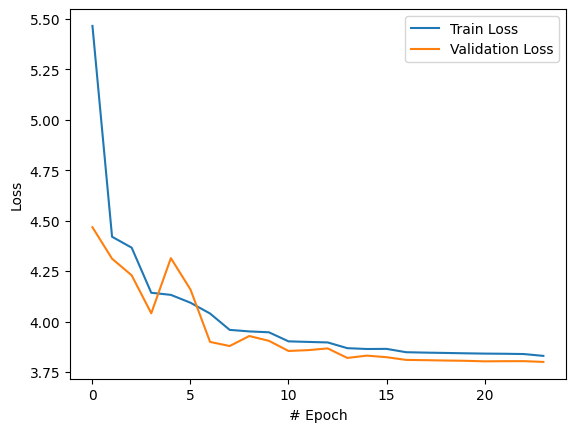

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.7998728794803323 to 3.7991290877930735
Epoch:  25/50 | Training pTLoss:  3.828297539502465 | Testing pTLoss:  3.7991290877930735


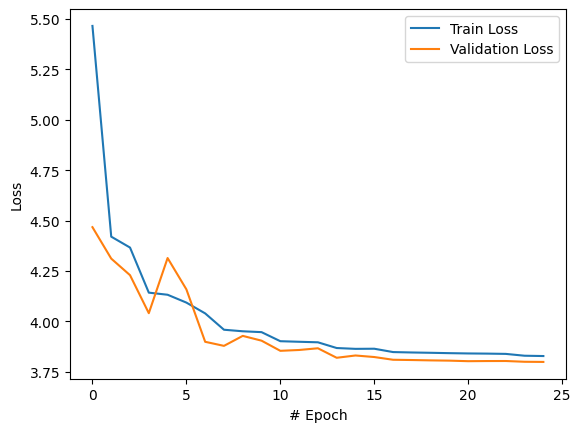

  0%|          | 0/1843 [00:00<?, ?it/s]

Epoch:  26/50 | Training pTLoss:  3.8274007823502196 | Testing pTLoss:  3.7994245648254785


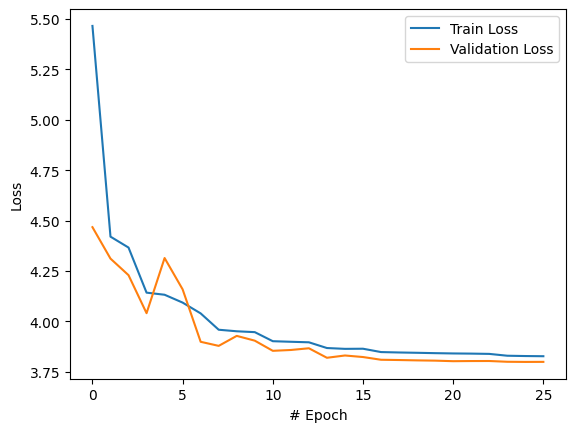

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.7991290877930735 to 3.799089025714132
Epoch 00027: reducing learning rate of group 0 to 1.5625e-04.
Epoch:  27/50 | Training pTLoss:  3.826638206152319 | Testing pTLoss:  3.799089025714132


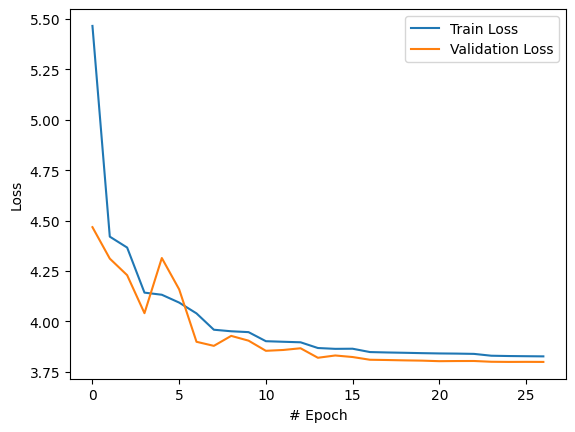

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.799089025714132 to 3.797818072641234
Epoch:  28/50 | Training pTLoss:  3.821566895758141 | Testing pTLoss:  3.797818072641234


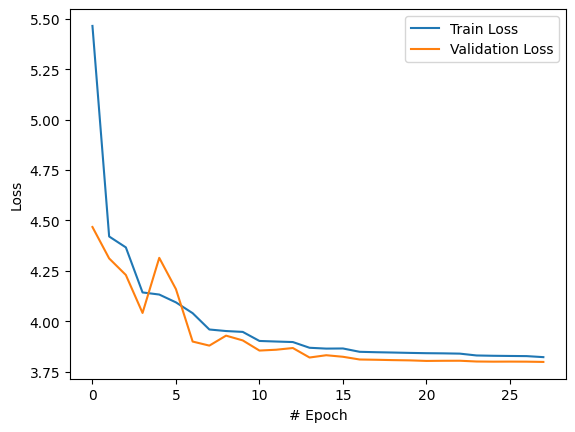

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.797818072641234 to 3.7970988978662104
Epoch:  29/50 | Training pTLoss:  3.8207903411552695 | Testing pTLoss:  3.7970988978662104


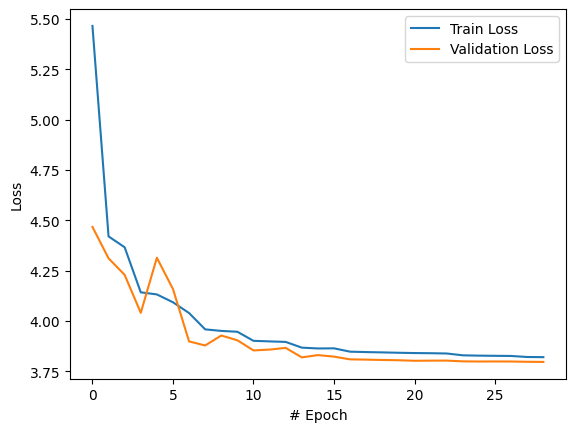

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.7970988978662104 to 3.796816448392165
Epoch:  30/50 | Training pTLoss:  3.820233942889281 | Testing pTLoss:  3.796816448392165


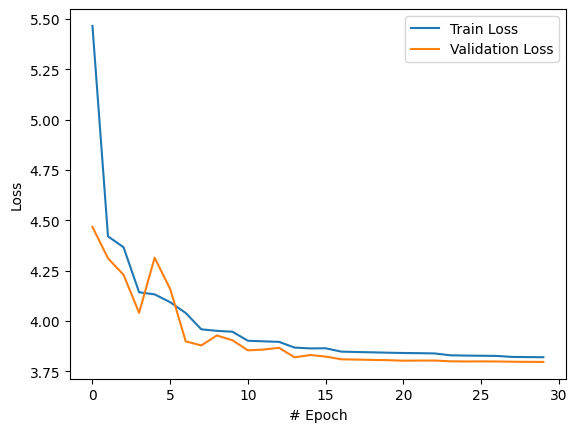

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.796816448392165 to 3.7965984899801235
Epoch:  31/50 | Training pTLoss:  3.819866036178621 | Testing pTLoss:  3.7965984899801235


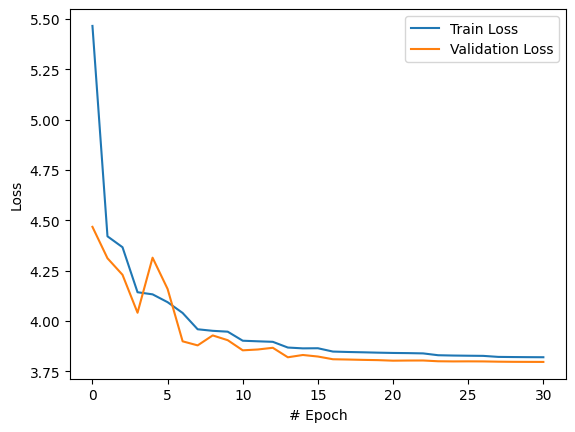

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.7965984899801235 to 3.7965831218727795
Epoch:  32/50 | Training pTLoss:  3.819443332521541 | Testing pTLoss:  3.7965831218727795


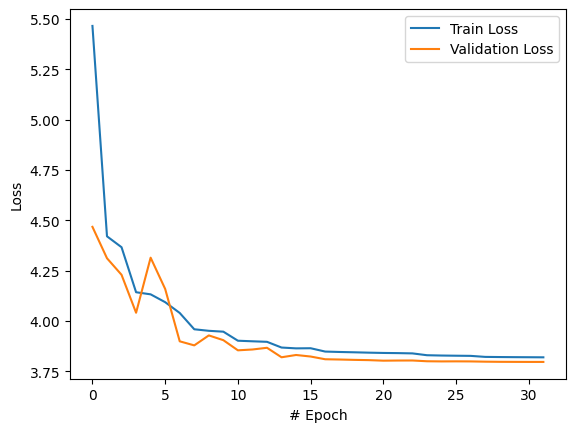

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.7965831218727795 to 3.7962619142521974
Epoch 00033: reducing learning rate of group 0 to 7.8125e-05.
Epoch:  33/50 | Training pTLoss:  3.8190811745058335 | Testing pTLoss:  3.7962619142521974


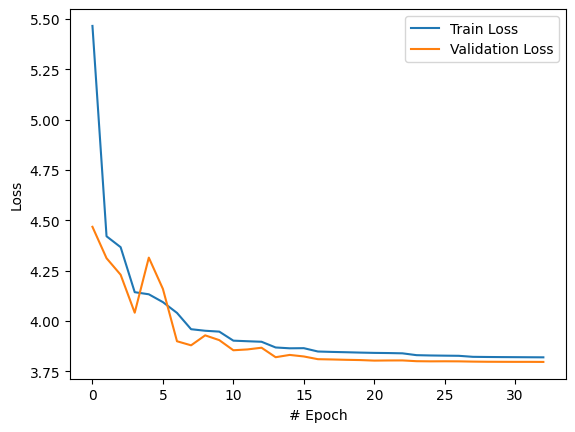

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.7962619142521974 to 3.7957545281620204
Epoch:  34/50 | Training pTLoss:  3.8160740232183112 | Testing pTLoss:  3.7957545281620204


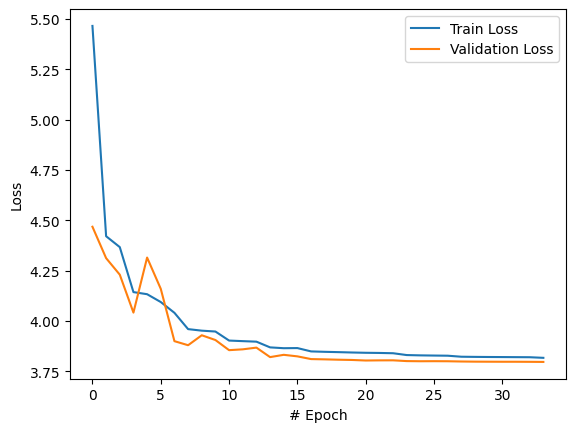

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.7957545281620204 to 3.7954819269656115
Epoch:  35/50 | Training pTLoss:  3.815611660965622 | Testing pTLoss:  3.7954819269656115


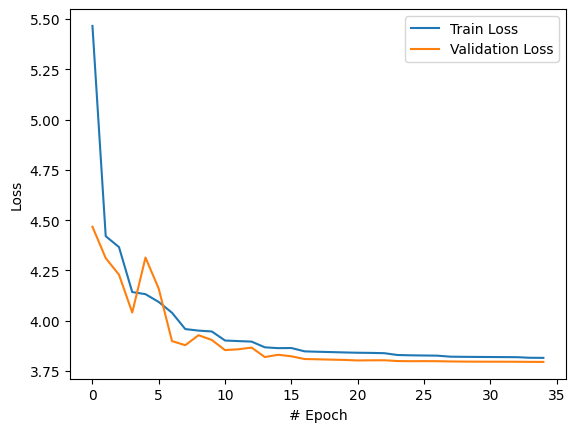

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.7954819269656115 to 3.795271030992852
Epoch:  36/50 | Training pTLoss:  3.8153456589222214 | Testing pTLoss:  3.795271030992852


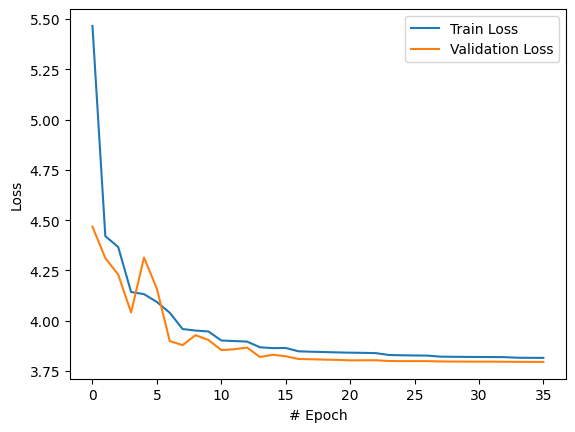

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.795271030992852 to 3.795042572272317
Epoch:  37/50 | Training pTLoss:  3.8150846338504967 | Testing pTLoss:  3.795042572272317


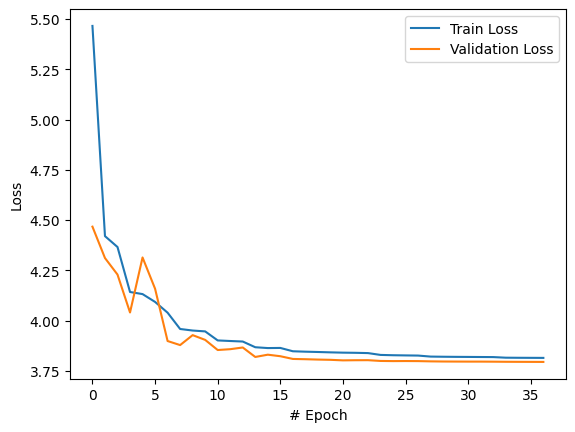

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.795042572272317 to 3.794804951826557
Epoch:  38/50 | Training pTLoss:  3.8148807774919913 | Testing pTLoss:  3.794804951826557


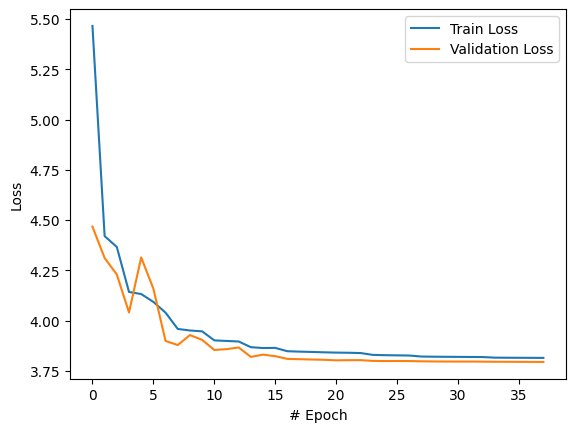

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.794804951826557 to 3.794761978235264
Epoch:  39/50 | Training pTLoss:  3.8146475292196587 | Testing pTLoss:  3.794761978235264


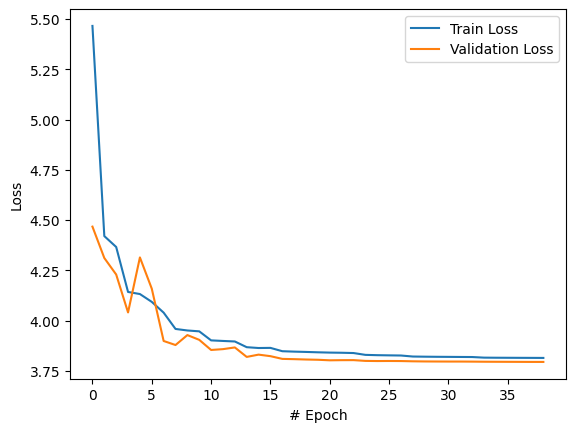

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.794761978235264 to 3.794601688868563
Epoch 00040: reducing learning rate of group 0 to 3.9063e-05.
Epoch:  40/50 | Training pTLoss:  3.8144474783735425 | Testing pTLoss:  3.794601688868563


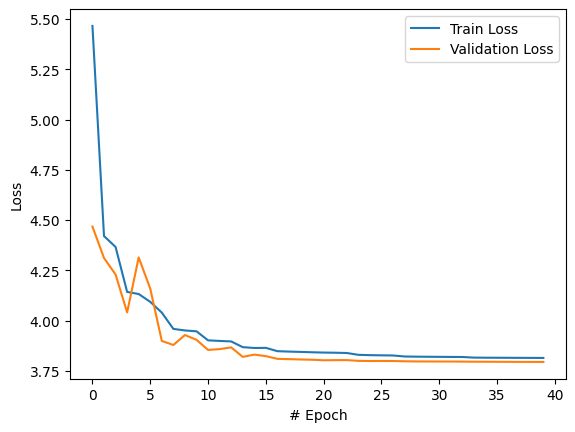

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.794601688868563 to 3.7935342021334972
Epoch:  41/50 | Training pTLoss:  3.812768767401375 | Testing pTLoss:  3.7935342021334972


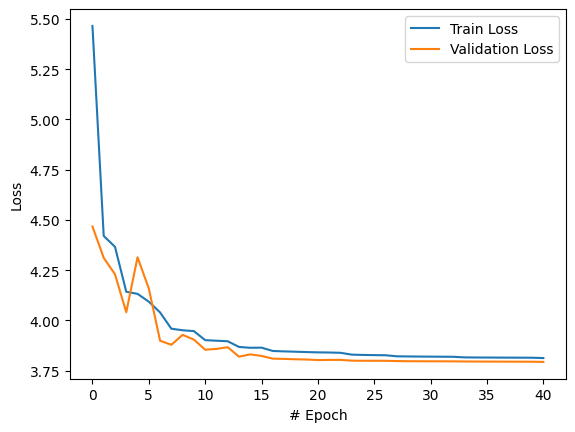

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.7935342021334972 to 3.7935086797090514
Epoch:  42/50 | Training pTLoss:  3.8125111094907864 | Testing pTLoss:  3.7935086797090514


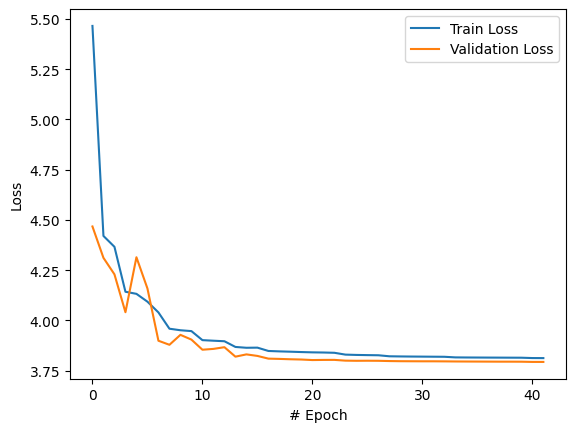

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.7935086797090514 to 3.793460945051302
Epoch 00043: reducing learning rate of group 0 to 1.9531e-05.
Epoch:  43/50 | Training pTLoss:  3.81233919960484 | Testing pTLoss:  3.793460945051302


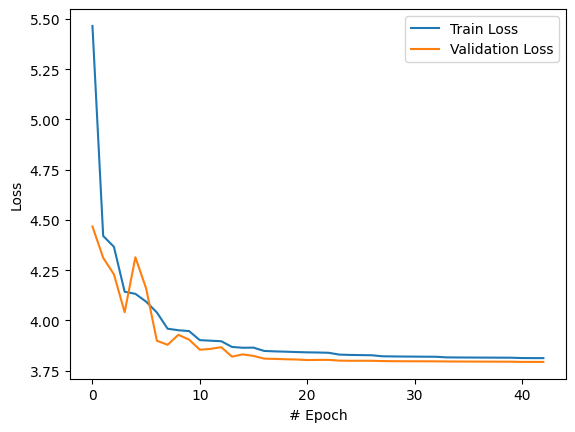

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.793460945051302 to 3.7928455137120443
Epoch:  44/50 | Training pTLoss:  3.811369940953874 | Testing pTLoss:  3.7928455137120443


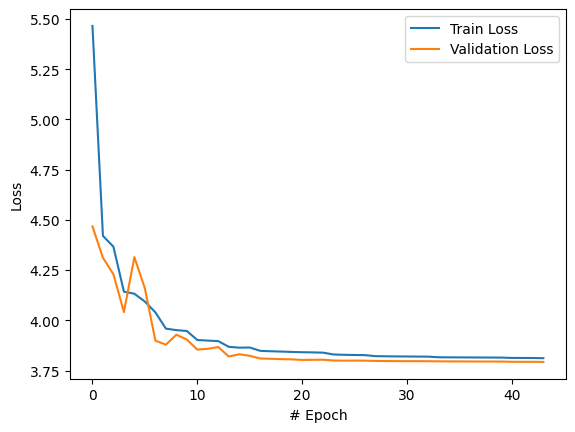

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.7928455137120443 to 3.7927641196907715
Epoch:  45/50 | Training pTLoss:  3.8112550592267223 | Testing pTLoss:  3.7927641196907715


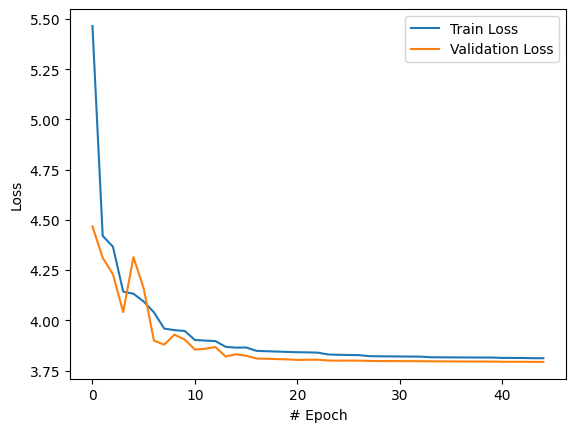

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.7927641196907715 to 3.792727364118085
Epoch 00046: reducing learning rate of group 0 to 9.7656e-06.
Epoch:  46/50 | Training pTLoss:  3.8111667981693627 | Testing pTLoss:  3.792727364118085


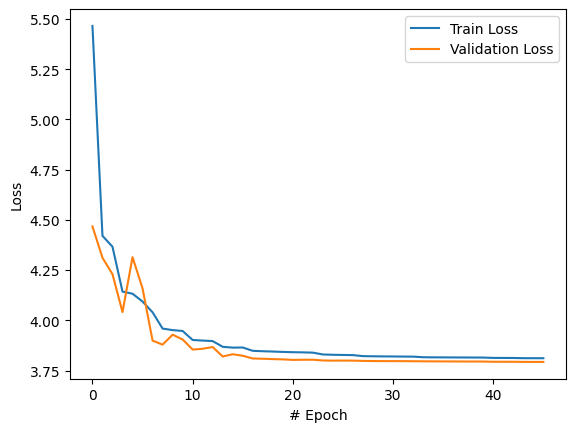

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.792727364118085 to 3.7926410530368573
Epoch:  47/50 | Training pTLoss:  3.8105930836383117 | Testing pTLoss:  3.7926410530368573


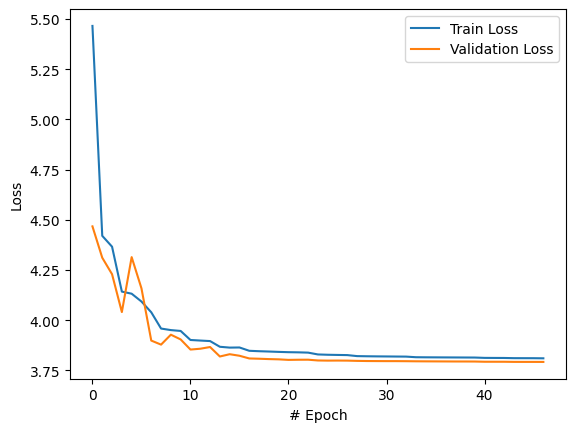

  0%|          | 0/1843 [00:00<?, ?it/s]

Min loss changed from 3.7926410530368573 to 3.7926102790682537
Epoch 00048: reducing learning rate of group 0 to 4.8828e-06.
Epoch:  48/50 | Training pTLoss:  3.810545872361253 | Testing pTLoss:  3.7926102790682537


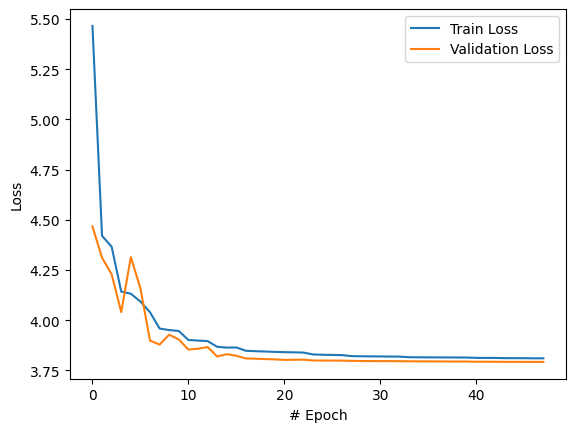

  0%|          | 0/1843 [00:00<?, ?it/s]

Epoch:  49/50 | Training pTLoss:  3.810225361789367 | Testing pTLoss:  3.7926378058766606


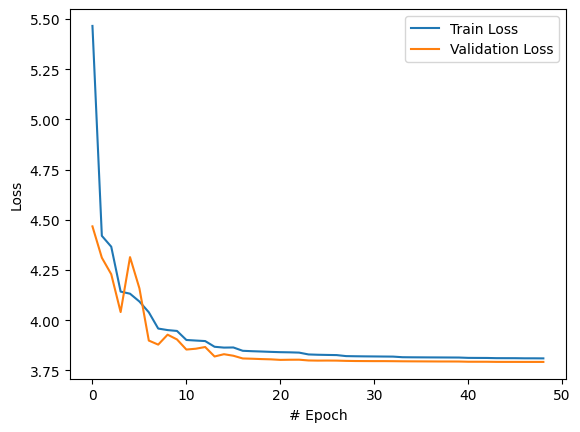

  0%|          | 0/1843 [00:00<?, ?it/s]

Epoch 00050: reducing learning rate of group 0 to 2.4414e-06.
Epoch:  50/50 | Training pTLoss:  3.8101995858690776 | Testing pTLoss:  3.7926362468467087


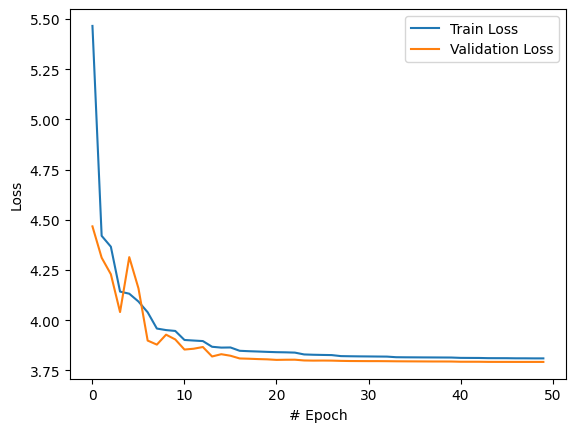

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 50
model = MODEL_GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=5e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=1, factor=0.5)

model_name = '/kaggle/working/model_trained/GNN_v1_pT_loss' + 'no_inv_' + '.pth'
os.makedirs("/kaggle/working/model_trained" , exist_ok =True)
train_losses, test_losses = train(train_loader, test_loader, prog_bar=True)

# TESTING

In [30]:
model_name = '/kaggle/working/model_trained/GNN_v1_pT_loss' + 'no_inv_' + '.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_model = MODEL_GNN().to(device)
loaded_model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [31]:
test_los = 0
preds = []
true_labels = []
# criterion = nn.MSELoss()
for data in tqdm(test_loader, position=0):
    data = data.to(device)
    out = model(data)
    preds.append(out.cpu().detach().numpy())
    labels = data.y.cpu().detach().numpy()
    true_labels.append(labels)
    loss = pTLossTorch(out, data.y)
    test_los += loss.item() / len(test_loader)

# Convert lists to numpy arrays
preds = np.concatenate(preds, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Calculate R2 score
r2 = r2_score(true_labels, preds)

print('Test Loss:', test_los)
print('R2 Score:', r2)

  0%|          | 0/922 [00:00<?, ?it/s]

Test Loss: 3.792636245295179
R2 Score: -0.032276737425055435
